# Quantum Chemistry Hamiltonians

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/block-hczhai/block2-preview/blob/master/docs/source/tutorial/qc-hamiltonians.ipynb)

In [1]:
!pip install block2==0.5.3rc5 -qq --progress-bar off --extra-index-url=https://block-hczhai.github.io/block2-preview/pypi/
!pip install pyscf==2.3.0 -qq --progress-bar off

## Introduction

In this tutorial we explain how to perform quantum chemistry DMRG using the python interface of ``block2``.

The quantum chemistry Hamiltonian in its second quantized form has to be defined in a set of orbitals, such as the Hartree-Fock (or Density Functional Theory) orbitals. The symmetries that can be used in the DMRG calculation thus have a dependence on the symmetry of the Hartree-Fock orbitals.

1. For spin-restricted Hartree-Fock (RHF) orbitals, we can perform spin-adapted DMRG (``SU2`` mode in ``block2``) or non-spin-adapted DMRG with any lower symmetries (``SZ`` or ``SGF``).

2. For spin-unrestricted Hartree-Fock (UHF) orbitals, we can perform non-spin-adapted DMRG (``SZ`` mode in ``block2``) or DMRG with lower symmetries (such as ``SGF``).

3. For general Hartree-Fock (GHF) orbitals, we can perform DMRG in spin-orbitals (``SGF`` mode in ``block2``) or first translate the Hamiltonian into the qubit Hamiltonian then do DMRG (``SGB`` mode in ``block2``).

4. For relativistic Dirac Hartree-Fock (DHF) orbitals, we can perform DMRG in complex spin-orbitals (``SGFCPX`` mode in ``block2``).

5. For atom and diatomic molecules, we can perform spin-adapted/non-spin-adapted/spin-orbital DMRG (``SAnySU2LZ/SAnySZLZ/SAnySGFLZ`` modes in ``block2``) with the $L_z$ symmetry.

Next, we will explain how to set up the integrals and perform DMRG in each of the modes (1) (2) (3) (4) and (5). The quantum chemistry integrals will be generated using ``pyscf`` and transformed using funtions defined in ``pyblock2._pyscf.ao2mo``.


In [2]:
import numpy as np
from pyblock2._pyscf.ao2mo import integrals as itg
from pyblock2.driver.core import DMRGDriver, SymmetryTypes

bond_dims = [250] * 4 + [500] * 4
noises = [1e-4] * 4 + [1e-5] * 4 + [0]
thrds = [1e-10] * 8

## Spin-Restricted Integrals

Here we use ``get_rhf_integrals`` function to get the integrals. Note that in order to do DMRG in a CASCI space, one can set the ``ncore`` (number of core orbitals) and ``ncas`` (number of active orbitals) parameters in ``get_*_integrals``. ``ncas=None`` will include all orbitals in DMRG.

For medium to large scale DMRG calculations, it is highly recommended to use a scratch space with high IO speed rather than the ``./tmp`` used in the following example. One also needs to set a suitable ``stack_mem`` in the ``DMRGDriver`` constructor to set the memory used for storing renormalized operators (in bytes). The default is ``stack_mem=int(1024**3)`` (1 GB). For medium scale calculations 10 to 30 GB might be required.

For the meaning of DMRG parameters, please have a look at the [Hubbard - Run DMRG](https://block2.readthedocs.io/en/latest/tutorial/hubbard.html#Run-DMRG) page.

In [3]:
from pyscf import gto, scf

mol = gto.M(atom="N 0 0 0; N 0 0 1.1", basis="sto3g", symmetry="d2h", verbose=0)
mf = scf.RHF(mol).run(conv_tol=1E-14)
ncas, n_elec, spin, ecore, h1e, g2e, orb_sym = itg.get_rhf_integrals(mf,
    ncore=0, ncas=None, g2e_symm=8)

driver = DMRGDriver(scratch="./tmp", symm_type=SymmetryTypes.SU2, n_threads=4)
driver.initialize_system(n_sites=ncas, n_elec=n_elec, spin=spin, orb_sym=orb_sym)

mpo = driver.get_qc_mpo(h1e=h1e, g2e=g2e, ecore=ecore, iprint=1)
ket = driver.get_random_mps(tag="GS", bond_dim=250, nroots=1)
energy = driver.dmrg(mpo, ket, n_sweeps=20, bond_dims=bond_dims, noises=noises,
    thrds=thrds, iprint=1)
print('DMRG energy = %20.15f' % energy)

pdm1 = driver.get_1pdm(ket)
pdm2 = driver.get_2pdm(ket).transpose(0, 3, 1, 2)
print('Energy from pdms = %20.15f' % (np.einsum('ij,ij->', pdm1, h1e)
    + 0.5 * np.einsum('ijkl,ijkl->', pdm2, driver.unpack_g2e(g2e)) + ecore))

impo = driver.get_identity_mpo()
expt = driver.expectation(ket, mpo, ket) / driver.expectation(ket, impo, ket)
print('Energy from expectation = %20.15f' % expt)

integral symmetrize error =  5.5986859646912075e-14
integral cutoff error =  0.0
mpo terms =       1030

Build MPO | Nsites =    10 | Nterms =       1030 | Algorithm = FastBIP | Cutoff = 1.00e-20
 Site =     0 /    10 .. Mmpo =    13 DW = 0.00e+00 NNZ =       13 SPT = 0.0000 Tmvc = 0.000 T = 0.008
 Site =     1 /    10 .. Mmpo =    34 DW = 0.00e+00 NNZ =       63 SPT = 0.8575 Tmvc = 0.000 T = 0.004
 Site =     2 /    10 .. Mmpo =    56 DW = 0.00e+00 NNZ =      121 SPT = 0.9364 Tmvc = 0.001 T = 0.004
 Site =     3 /    10 .. Mmpo =    74 DW = 0.00e+00 NNZ =      373 SPT = 0.9100 Tmvc = 0.000 T = 0.004
 Site =     4 /    10 .. Mmpo =    80 DW = 0.00e+00 NNZ =      269 SPT = 0.9546 Tmvc = 0.000 T = 0.004
 Site =     5 /    10 .. Mmpo =    94 DW = 0.00e+00 NNZ =      169 SPT = 0.9775 Tmvc = 0.000 T = 0.004
 Site =     6 /    10 .. Mmpo =    54 DW = 0.00e+00 NNZ =      181 SPT = 0.9643 Tmvc = 0.000 T = 0.003
 Site =     7 /    10 .. Mmpo =    30 DW = 0.00e+00 NNZ =       73 SPT = 0.9549 Tmv

We can also run non-spin-adapted DMRG (``SZ`` mode) using the restricted integrals.

In [4]:
driver = DMRGDriver(scratch="./tmp", symm_type=SymmetryTypes.SZ, n_threads=4)
driver.initialize_system(n_sites=ncas, n_elec=n_elec, spin=spin, orb_sym=orb_sym)

mpo = driver.get_qc_mpo(h1e=h1e, g2e=g2e, ecore=ecore, iprint=1)
ket = driver.get_random_mps(tag="GS", bond_dim=250, nroots=1)
energy = driver.dmrg(mpo, ket, n_sweeps=20, bond_dims=bond_dims, noises=noises,
    thrds=thrds, iprint=1)
print('DMRG energy = %20.15f' % energy)

integral symmetrize error =  7.225136772727681e-14
integral cutoff error =  0.0
mpo terms =       2778

Build MPO | Nsites =    10 | Nterms =       2778 | Algorithm = FastBIP | Cutoff = 1.00e-20
 Site =     0 /    10 .. Mmpo =    26 DW = 0.00e+00 NNZ =       26 SPT = 0.0000 Tmvc = 0.001 T = 0.034
 Site =     1 /    10 .. Mmpo =    66 DW = 0.00e+00 NNZ =      143 SPT = 0.9167 Tmvc = 0.001 T = 0.034
 Site =     2 /    10 .. Mmpo =   110 DW = 0.00e+00 NNZ =      283 SPT = 0.9610 Tmvc = 0.011 T = 0.042
 Site =     3 /    10 .. Mmpo =   138 DW = 0.00e+00 NNZ =     1023 SPT = 0.9326 Tmvc = 0.004 T = 0.018
 Site =     4 /    10 .. Mmpo =   158 DW = 0.00e+00 NNZ =      535 SPT = 0.9755 Tmvc = 0.001 T = 0.046
 Site =     5 /    10 .. Mmpo =   186 DW = 0.00e+00 NNZ =      463 SPT = 0.9842 Tmvc = 0.001 T = 0.015
 Site =     6 /    10 .. Mmpo =   106 DW = 0.00e+00 NNZ =      415 SPT = 0.9790 Tmvc = 0.001 T = 0.021
 Site =     7 /    10 .. Mmpo =    58 DW = 0.00e+00 NNZ =      163 SPT = 0.9735 Tmvc

We can also run DMRG in spin orbitals (``SGF`` mode) using the restricted integrals, which will be much slower (for more realistic systems).

In [5]:
driver = DMRGDriver(scratch="./tmp", symm_type=SymmetryTypes.SGF, n_threads=4)

driver.n_sites = ncas
g2e = driver.unpack_g2e(g2e)
orb_sym = [orb_sym[i // 2] for i in range(len(orb_sym) * 2)]
n_sites = ncas * 2

driver.initialize_system(n_sites=n_sites, n_elec=n_elec, orb_sym=orb_sym)

mpo = driver.get_qc_mpo(h1e=h1e, g2e=g2e, ecore=ecore, iprint=1)
ket = driver.get_random_mps(tag="GS", bond_dim=250, nroots=1)
energy = driver.dmrg(mpo, ket, n_sweeps=20, bond_dims=bond_dims, noises=noises,
    thrds=thrds, iprint=1)
print('DMRG energy = %20.15f' % energy)

integral symmetrize error =  7.225136772727683e-14
integral cutoff error =  0.0
mpo terms =       2438

Build MPO | Nsites =    20 | Nterms =       2438 | Algorithm = FastBIP | Cutoff = 1.00e-20
 Site =     0 /    20 .. Mmpo =     7 DW = 0.00e+00 NNZ =        7 SPT = 0.0000 Tmvc = 0.000 T = 0.005
 Site =     1 /    20 .. Mmpo =    20 DW = 0.00e+00 NNZ =       19 SPT = 0.8643 Tmvc = 0.001 T = 0.010
 Site =     2 /    20 .. Mmpo =    45 DW = 0.00e+00 NNZ =       45 SPT = 0.9500 Tmvc = 0.001 T = 0.012
 Site =     3 /    20 .. Mmpo =    62 DW = 0.00e+00 NNZ =      131 SPT = 0.9530 Tmvc = 0.001 T = 0.020
 Site =     4 /    20 .. Mmpo =    81 DW = 0.00e+00 NNZ =      159 SPT = 0.9683 Tmvc = 0.002 T = 0.008
 Site =     5 /    20 .. Mmpo =   104 DW = 0.00e+00 NNZ =      203 SPT = 0.9759 Tmvc = 0.001 T = 0.009
 Site =     6 /    20 .. Mmpo =   125 DW = 0.00e+00 NNZ =      265 SPT = 0.9796 Tmvc = 0.002 T = 0.019
 Site =     7 /    20 .. Mmpo =   126 DW = 0.00e+00 NNZ =      974 SPT = 0.9382 Tmvc

## Read and Write FCIDUMP Files

Instead of generating integrals (``h1e`` and ``g2e``) using ``pyscf``, we can also read these integrals from a FCIDUMP file (which can be generated using any of many other quantum chemistry packages) then perform DMRG. Additionally, we also provide methods to write the FCIDUMP file using the data in the ``h1e`` and ``g2e`` arrays.

After invoking ``driver.read_fcidump``, the integrals and target state infomation can be obtained from ``driver.h1e``, ``driver.g2e``, ``driver.n_sites``, etc.

In [6]:
from pyscf import gto, scf

mol = gto.M(atom="N 0 0 0; N 0 0 1.1", basis="sto3g", symmetry="d2h", verbose=0)
mf = scf.RHF(mol).run(conv_tol=1E-14)
ncas, n_elec, spin, ecore, h1e, g2e, orb_sym = itg.get_rhf_integrals(mf,
    ncore=0, ncas=None, g2e_symm=8)

driver = DMRGDriver(scratch="./tmp", symm_type=SymmetryTypes.SU2, n_threads=4)

# write integrals to file
driver.initialize_system(n_sites=ncas, n_elec=n_elec, spin=spin, orb_sym=orb_sym)
driver.write_fcidump(h1e, g2e, ecore, filename='N2.STO3G.FCIDUMP', h1e_symm=True, pg='d2h')

# read integrals from file
driver.read_fcidump(filename='N2.STO3G.FCIDUMP', pg='d2h')
driver.initialize_system(n_sites=driver.n_sites, n_elec=driver.n_elec,
                         spin=driver.spin, orb_sym=driver.orb_sym)

mpo = driver.get_qc_mpo(h1e=driver.h1e, g2e=driver.g2e, ecore=driver.ecore, iprint=1)
ket = driver.get_random_mps(tag="GS", bond_dim=250, nroots=1)
energy = driver.dmrg(mpo, ket, n_sweeps=20, bond_dims=bond_dims, noises=noises,
    thrds=thrds, iprint=1)
print('DMRG energy = %20.15f' % energy)

symmetrize error =  2.4200000000000016e-14
integral symmetrize error =  0.0
integral cutoff error =  0.0
mpo terms =       1030

Build MPO | Nsites =    10 | Nterms =       1030 | Algorithm = FastBIP | Cutoff = 1.00e-20
 Site =     0 /    10 .. Mmpo =    13 DW = 0.00e+00 NNZ =       13 SPT = 0.0000 Tmvc = 0.001 T = 0.015
 Site =     1 /    10 .. Mmpo =    34 DW = 0.00e+00 NNZ =       63 SPT = 0.8575 Tmvc = 0.002 T = 0.008
 Site =     2 /    10 .. Mmpo =    56 DW = 0.00e+00 NNZ =      121 SPT = 0.9364 Tmvc = 0.001 T = 0.008
 Site =     3 /    10 .. Mmpo =    74 DW = 0.00e+00 NNZ =      373 SPT = 0.9100 Tmvc = 0.001 T = 0.008
 Site =     4 /    10 .. Mmpo =    80 DW = 0.00e+00 NNZ =      269 SPT = 0.9546 Tmvc = 0.004 T = 0.019
 Site =     5 /    10 .. Mmpo =    94 DW = 0.00e+00 NNZ =      169 SPT = 0.9775 Tmvc = 0.000 T = 0.005
 Site =     6 /    10 .. Mmpo =    54 DW = 0.00e+00 NNZ =      181 SPT = 0.9643 Tmvc = 0.000 T = 0.004
 Site =     7 /    10 .. Mmpo =    30 DW = 0.00e+00 NNZ =  

## The ``SZ`` Mode

Here we use ``get_uhf_integrals`` function to get the integrals.

In [7]:
from pyscf import gto, scf

mol = gto.M(atom="N 0 0 0; N 0 0 1.1", basis="sto3g", symmetry="d2h", verbose=0)
mf = scf.UHF(mol).run(conv_tol=1E-14)
ncas, n_elec, spin, ecore, h1e, g2e, orb_sym = itg.get_uhf_integrals(mf,
    ncore=0, ncas=None, g2e_symm=8)

driver = DMRGDriver(scratch="./tmp", symm_type=SymmetryTypes.SZ, n_threads=4)
driver.initialize_system(n_sites=ncas, n_elec=n_elec, spin=spin, orb_sym=orb_sym)

mpo = driver.get_qc_mpo(h1e=h1e, g2e=g2e, ecore=ecore, iprint=1)
ket = driver.get_random_mps(tag="GS", bond_dim=250, nroots=1)
energy = driver.dmrg(mpo, ket, n_sweeps=20, bond_dims=bond_dims, noises=noises,
    thrds=thrds, iprint=1)
print('DMRG energy = %20.15f' % energy)

integral symmetrize error =  1.5510746027850855e-13
integral cutoff error =  0.0
mpo terms =       2778

Build MPO | Nsites =    10 | Nterms =       2778 | Algorithm = FastBIP | Cutoff = 1.00e-20
 Site =     0 /    10 .. Mmpo =    26 DW = 0.00e+00 NNZ =       26 SPT = 0.0000 Tmvc = 0.001 T = 0.014
 Site =     1 /    10 .. Mmpo =    66 DW = 0.00e+00 NNZ =      143 SPT = 0.9167 Tmvc = 0.001 T = 0.015
 Site =     2 /    10 .. Mmpo =   110 DW = 0.00e+00 NNZ =      283 SPT = 0.9610 Tmvc = 0.002 T = 0.013
 Site =     3 /    10 .. Mmpo =   138 DW = 0.00e+00 NNZ =     1023 SPT = 0.9326 Tmvc = 0.001 T = 0.011
 Site =     4 /    10 .. Mmpo =   158 DW = 0.00e+00 NNZ =      535 SPT = 0.9755 Tmvc = 0.001 T = 0.010
 Site =     5 /    10 .. Mmpo =   186 DW = 0.00e+00 NNZ =      463 SPT = 0.9842 Tmvc = 0.001 T = 0.008
 Site =     6 /    10 .. Mmpo =   106 DW = 0.00e+00 NNZ =      415 SPT = 0.9790 Tmvc = 0.000 T = 0.008
 Site =     7 /    10 .. Mmpo =    58 DW = 0.00e+00 NNZ =      163 SPT = 0.9735 Tmv

## The ``SGF`` Mode

Here we use ``get_ghf_integrals`` function to get the integrals.

In [8]:
from pyscf import gto, scf

mol = gto.M(atom="N 0 0 0; N 0 0 1.1", basis="sto3g", symmetry="d2h", verbose=0)
mf = scf.GHF(mol).run(conv_tol=1E-14)
ncas, n_elec, spin, ecore, h1e, g2e, orb_sym = itg.get_ghf_integrals(mf,
    ncore=0, ncas=None, g2e_symm=8)

driver = DMRGDriver(scratch="./tmp", symm_type=SymmetryTypes.SGF, n_threads=4)
driver.initialize_system(n_sites=ncas, n_elec=n_elec, orb_sym=orb_sym)

mpo = driver.get_qc_mpo(h1e=h1e, g2e=g2e, ecore=ecore, iprint=1)
ket = driver.get_random_mps(tag="GS", bond_dim=250, nroots=1)
energy = driver.dmrg(mpo, ket, n_sweeps=20, bond_dims=bond_dims, noises=noises,
    thrds=thrds, iprint=1)
print('DMRG energy = %20.15f' % energy)

integral symmetrize error =  2.2056297680002223e-13
integral cutoff error =  0.0
mpo terms =       5992

Build MPO | Nsites =    20 | Nterms =       5992 | Algorithm = FastBIP | Cutoff = 1.00e-20
 Site =     0 /    20 .. Mmpo =     7 DW = 0.00e+00 NNZ =        7 SPT = 0.0000 Tmvc = 0.001 T = 0.017
 Site =     1 /    20 .. Mmpo =    20 DW = 0.00e+00 NNZ =       19 SPT = 0.8643 Tmvc = 0.001 T = 0.014
 Site =     2 /    20 .. Mmpo =    47 DW = 0.00e+00 NNZ =       49 SPT = 0.9479 Tmvc = 0.002 T = 0.015
 Site =     3 /    20 .. Mmpo =    62 DW = 0.00e+00 NNZ =      251 SPT = 0.9139 Tmvc = 0.002 T = 0.011
 Site =     4 /    20 .. Mmpo =    81 DW = 0.00e+00 NNZ =      273 SPT = 0.9456 Tmvc = 0.003 T = 0.020
 Site =     5 /    20 .. Mmpo =   104 DW = 0.00e+00 NNZ =      357 SPT = 0.9576 Tmvc = 0.001 T = 0.013
 Site =     6 /    20 .. Mmpo =   129 DW = 0.00e+00 NNZ =      563 SPT = 0.9580 Tmvc = 0.002 T = 0.011
 Site =     7 /    20 .. Mmpo =   126 DW = 0.00e+00 NNZ =     2318 SPT = 0.8574 Tmv

## The ``SGB`` Mode

In this section, we try to solve the problem by first transfroming the model into a qubit (spin) model. The code will automatically use Jordan-Wigner transform to change the fermionic operators in the Hamiltonian into spin operators, before constructing the MPO.

To use the ``SGB`` mode for ab initio systems, remember to add the ``heis_twos=1`` parameter (indicating the 1/2 spin at each site) in ``driver.initialize_system``.

In [9]:
from pyscf import gto, scf

mol = gto.M(atom="N 0 0 0; N 0 0 1.1", basis="sto3g", symmetry="d2h", verbose=0)
mf = scf.GHF(mol).run(conv_tol=1E-14)
ncas, n_elec, spin, ecore, h1e, g2e, orb_sym = itg.get_ghf_integrals(mf,
    ncore=0, ncas=None, g2e_symm=8)

driver = DMRGDriver(scratch="./tmp", symm_type=SymmetryTypes.SGB, n_threads=4)
driver.initialize_system(n_sites=ncas, n_elec=n_elec, orb_sym=orb_sym, heis_twos=1)

mpo = driver.get_qc_mpo(h1e=h1e, g2e=g2e, ecore=ecore, iprint=1)
ket = driver.get_random_mps(tag="GS", bond_dim=250, nroots=1)
energy = driver.dmrg(mpo, ket, n_sweeps=20, bond_dims=bond_dims, noises=noises,
    thrds=thrds, iprint=1)
print('DMRG energy = %20.15f' % energy)

integral symmetrize error =  2.03655637126935e-13
integral cutoff error =  0.0
mpo terms =       5906

Build MPO | Nsites =    20 | Nterms =       5906 | Algorithm = FastBIP | Cutoff = 1.00e-20
 Site =     0 /    20 .. Mmpo =     7 DW = 0.00e+00 NNZ =        7 SPT = 0.0000 Tmvc = 0.001 T = 0.009
 Site =     1 /    20 .. Mmpo =    20 DW = 0.00e+00 NNZ =       19 SPT = 0.8643 Tmvc = 0.001 T = 0.011
 Site =     2 /    20 .. Mmpo =    47 DW = 0.00e+00 NNZ =       49 SPT = 0.9479 Tmvc = 0.002 T = 0.012
 Site =     3 /    20 .. Mmpo =    62 DW = 0.00e+00 NNZ =      251 SPT = 0.9139 Tmvc = 0.002 T = 0.017
 Site =     4 /    20 .. Mmpo =    81 DW = 0.00e+00 NNZ =      273 SPT = 0.9456 Tmvc = 0.003 T = 0.018
 Site =     5 /    20 .. Mmpo =   104 DW = 0.00e+00 NNZ =      357 SPT = 0.9576 Tmvc = 0.002 T = 0.014
 Site =     6 /    20 .. Mmpo =   129 DW = 0.00e+00 NNZ =      563 SPT = 0.9580 Tmvc = 0.003 T = 0.017
 Site =     7 /    20 .. Mmpo =   126 DW = 0.00e+00 NNZ =     2318 SPT = 0.8574 Tmvc 

## Relativistic DMRG

For relativistic DMRG, we use ``get_dhf_integrals`` function to get the integrals. We use the ``SGFCPX`` Mode in ``block2`` to execute DMRG. Note that the integrals, MPO, and MPS will all contain complex numbers in this mode.

The ``symm_type`` parameter ``SymmetryTypes.SGFCPX`` can also be written as ``SymmetryTypes.SGF | SymmetryTypes.CPX``.

In [10]:
from pyscf import gto, scf

mol = gto.M(atom="N 0 0 0; N 0 0 1.1", basis="sto3g", symmetry="d2h", verbose=0)
mf = scf.DHF(mol).set(with_gaunt=True, with_breit=True).run(conv_tol=1E-12)
ncas, n_elec, spin, ecore, h1e, g2e, orb_sym = itg.get_dhf_integrals(mf,
    ncore=0, ncas=None, pg_symm=False)

driver = DMRGDriver(scratch="./tmp", symm_type=SymmetryTypes.SGFCPX, n_threads=4)
driver.initialize_system(n_sites=ncas, n_elec=n_elec, orb_sym=orb_sym)

mpo = driver.get_qc_mpo(h1e=h1e, g2e=g2e, ecore=ecore, iprint=1)
ket = driver.get_random_mps(tag="GS", bond_dim=250, nroots=1)
energy = driver.dmrg(mpo, ket, n_sweeps=20, bond_dims=bond_dims, noises=noises,
    thrds=thrds, iprint=1)
print('DMRG energy = %20.15f' % energy)

integral symmetrize error =  0.0
integral cutoff error =  0.0
mpo terms =      44348

Build MPO | Nsites =    20 | Nterms =      44348 | Algorithm = FastBIP | Cutoff = 1.00e-20
 Site =     0 /    20 .. Mmpo =     9 DW = 0.00e+00 NNZ =        9 SPT = 0.0000 Tmvc = 0.004 T = 0.017
 Site =     1 /    20 .. Mmpo =    28 DW = 0.00e+00 NNZ =       23 SPT = 0.9087 Tmvc = 0.005 T = 0.020
 Site =     2 /    20 .. Mmpo =    63 DW = 0.00e+00 NNZ =      404 SPT = 0.7710 Tmvc = 0.006 T = 0.029
 Site =     3 /    20 .. Mmpo =    78 DW = 0.00e+00 NNZ =      589 SPT = 0.8801 Tmvc = 0.007 T = 0.029
 Site =     4 /    20 .. Mmpo =    97 DW = 0.00e+00 NNZ =      933 SPT = 0.8767 Tmvc = 0.007 T = 0.030
 Site =     5 /    20 .. Mmpo =   120 DW = 0.00e+00 NNZ =     1315 SPT = 0.8870 Tmvc = 0.008 T = 0.032
 Site =     6 /    20 .. Mmpo =   147 DW = 0.00e+00 NNZ =     1722 SPT = 0.9024 Tmvc = 0.010 T = 0.038
 Site =     7 /    20 .. Mmpo =   178 DW = 0.00e+00 NNZ =     2141 SPT = 0.9182 Tmvc = 0.009 T = 0.034

## The ``LZ`` Mode

For diatomic molecules, we can set symmetry ``dooh`` in ``pyscf``, and then use ``itg.lz_symm_adaptation`` to adapt the atomic orbitals for the ``LZ`` symmetry before running Hartree-Fock. Then we can use the ``LZ`` modes in ``block2`` to perform DMRG.

The ``LZ`` mode can be combined with ``SU2``, ``SZ`` or ``SGF`` spin symmetries, and the ``SAny`` prefix in ``SymmetryTypes``. To activate the ``SAny`` prefix, the ``block2`` code needs to be compiled with the ``-DUSE_SANY=ON`` option (this option is ON by default in the ``pip`` precompiled binaries). Optionally, when ``-DUSE_SANY=ON``, one can also set ``-DUSE_SG=OFF -DUSE_SU2SZ=OFF`` to disable the normal ``SU2/SZ/SGF`` modes. One can use ``SymmetryTypes.SAnySU2/SymmetryTypes.SAnySZ/SymmetryTypes.SAnySGF`` instead for normal symmetries (with some limitations) when ``-DUSE_SG=OFF -DUSE_SU2SZ=OFF`` is used.

With ``SU2`` (spin-adapted DMRG):

In [11]:
mol = gto.M(atom="N 0 0 0; N 0 0 1.1", basis="sto3g", symmetry="dooh", verbose=0)
mol.symm_orb, z_irrep, g_irrep = itg.lz_symm_adaptation(mol)
mf = scf.RHF(mol).run(conv_tol=1E-14)
ncas, n_elec, spin, ecore, h1e, g2e, orb_sym_z = itg.get_rhf_integrals(mf,
    ncore=0, ncas=None, g2e_symm=1, irrep_id=z_irrep)
print(orb_sym_z)

driver = DMRGDriver(scratch="./tmp", symm_type=SymmetryTypes.SAnySU2LZ, n_threads=4)
driver.initialize_system(n_sites=ncas, n_elec=n_elec, spin=spin, orb_sym=orb_sym_z, pg_irrep=0)

mpo = driver.get_qc_mpo(h1e=h1e, g2e=g2e, ecore=ecore, iprint=1)
ket = driver.get_random_mps(tag="GS", bond_dim=250, nroots=1)
energy = driver.dmrg(mpo, ket, n_sweeps=20, bond_dims=bond_dims, noises=noises,
    thrds=thrds, iprint=1)
print('DMRG energy = %20.15f' % energy)

[ 0  0  0  0 -1  1  0  1 -1  0]
integral symmetrize error =  2.0562981879479644e-15
integral cutoff error =  6.776263578034403e-21
mpo terms =       1882

Build MPO | Nsites =    10 | Nterms =       1882 | Algorithm = FastBIP | Cutoff = 1.00e-20
 Site =     0 /    10 .. Mmpo =    14 DW = 0.00e+00 NNZ =       14 SPT = 0.0000 Tmvc = 0.001 T = 0.036
 Site =     1 /    10 .. Mmpo =    34 DW = 0.00e+00 NNZ =      106 SPT = 0.7773 Tmvc = 0.001 T = 0.049
 Site =     2 /    10 .. Mmpo =    56 DW = 0.00e+00 NNZ =      189 SPT = 0.9007 Tmvc = 0.001 T = 0.054
 Site =     3 /    10 .. Mmpo =    66 DW = 0.00e+00 NNZ =      824 SPT = 0.7771 Tmvc = 0.001 T = 0.058
 Site =     4 /    10 .. Mmpo =    88 DW = 0.00e+00 NNZ =      154 SPT = 0.9735 Tmvc = 0.001 T = 0.035
 Site =     5 /    10 .. Mmpo =    94 DW = 0.00e+00 NNZ =      318 SPT = 0.9616 Tmvc = 0.000 T = 0.029
 Site =     6 /    10 .. Mmpo =    64 DW = 0.00e+00 NNZ =      237 SPT = 0.9606 Tmvc = 0.000 T = 0.024
 Site =     7 /    10 .. Mmpo =  

With ``SZ`` (non-spin-adapted DMRG):

In [12]:
mol = gto.M(atom="N 0 0 0; N 0 0 1.1", basis="sto3g", symmetry="dooh", verbose=0)
mol.symm_orb, z_irrep, g_irrep = itg.lz_symm_adaptation(mol)
mf = scf.UHF(mol).run(conv_tol=1E-14)
ncas, n_elec, spin, ecore, h1e, g2e, orb_sym_z = itg.get_uhf_integrals(mf,
    ncore=0, ncas=None, g2e_symm=1, irrep_id=z_irrep)
print(orb_sym_z)

driver = DMRGDriver(scratch="./tmp", symm_type=SymmetryTypes.SAnySZLZ, n_threads=4)
driver.initialize_system(n_sites=ncas, n_elec=n_elec, spin=spin, orb_sym=orb_sym_z, pg_irrep=0)

mpo = driver.get_qc_mpo(h1e=h1e, g2e=g2e, ecore=ecore, iprint=1)
ket = driver.get_random_mps(tag="GS", bond_dim=250, nroots=1)
energy = driver.dmrg(mpo, ket, n_sweeps=20, bond_dims=bond_dims, noises=noises,
    thrds=thrds, iprint=1)
print('DMRG energy = %20.15f' % energy)

[ 0  0  0  0 -1  1  0  1 -1  0]
integral symmetrize error =  8.030340066584701e-15
integral cutoff error =  1.249373597200093e-20
mpo terms =       5237

Build MPO | Nsites =    10 | Nterms =       5237 | Algorithm = FastBIP | Cutoff = 1.00e-20
 Site =     0 /    10 .. Mmpo =    30 DW = 0.00e+00 NNZ =       30 SPT = 0.0000 Tmvc = 0.002 T = 0.077
 Site =     1 /    10 .. Mmpo =    66 DW = 0.00e+00 NNZ =      278 SPT = 0.8596 Tmvc = 0.001 T = 0.117
 Site =     2 /    10 .. Mmpo =   110 DW = 0.00e+00 NNZ =      478 SPT = 0.9342 Tmvc = 0.002 T = 0.126
 Site =     3 /    10 .. Mmpo =   123 DW = 0.00e+00 NNZ =     2285 SPT = 0.8311 Tmvc = 0.001 T = 0.131
 Site =     4 /    10 .. Mmpo =   170 DW = 0.00e+00 NNZ =      360 SPT = 0.9828 Tmvc = 0.001 T = 0.062
 Site =     5 /    10 .. Mmpo =   186 DW = 0.00e+00 NNZ =      814 SPT = 0.9743 Tmvc = 0.001 T = 0.065
 Site =     6 /    10 .. Mmpo =   126 DW = 0.00e+00 NNZ =      579 SPT = 0.9753 Tmvc = 0.001 T = 0.046
 Site =     7 /    10 .. Mmpo =   

With ``SGF`` (spin-orbital DMRG):

In [13]:
from pyscf.scf.ghf_symm import GHF
from pyscf import symm, lib
from pyscf.scf import hf_symm
import scipy.linalg
import numpy as np

# fix pyscf 2.3.0 bug in ghf_symm for complex orbtials
def ghf_eig(self, h, s, symm_orb=None, irrep_id=None):
    if symm_orb is None or irrep_id is None:
        mol = self.mol
        symm_orb = mol.symm_orb
        irrep_id = mol.irrep_id
    nirrep = len(symm_orb)
    symm_orb = [scipy.linalg.block_diag(c, c) for c in symm_orb]
    h = symm.symmetrize_matrix(h, symm_orb)
    s = symm.symmetrize_matrix(s, symm_orb)
    cs = []
    es = []
    orbsym = []
    for ir in range(nirrep):
        e, c = self._eigh(h[ir], s[ir])
        cs.append(c)
        es.append(e)
        orbsym.append([irrep_id[ir]] * e.size)
    e = np.hstack(es)
    c = hf_symm.so2ao_mo_coeff(symm_orb, cs)
    c = lib.tag_array(c, orbsym=np.hstack(orbsym))
    return e, c

GHF.eig = ghf_eig

mol = gto.M(atom="N 0 0 0; N 0 0 1.1", basis="sto3g", symmetry="dooh", verbose=0)
mol.symm_orb, z_irrep, g_irrep = itg.lz_symm_adaptation(mol)
mf = scf.GHF(mol).run(conv_tol=1E-14)
ncas, n_elec, spin, ecore, h1e, g2e, orb_sym_z = itg.get_ghf_integrals(mf,
    ncore=0, ncas=None, g2e_symm=1, irrep_id=z_irrep)
print(orb_sym_z)

driver = DMRGDriver(scratch="./tmp", symm_type=SymmetryTypes.SAnySGFLZ, n_threads=4)
driver.initialize_system(n_sites=ncas, n_elec=n_elec, orb_sym=orb_sym_z, pg_irrep=0)

mpo = driver.get_qc_mpo(h1e=h1e, g2e=g2e, ecore=ecore, iprint=1)
ket = driver.get_random_mps(tag="GS", bond_dim=250, nroots=1)
energy = driver.dmrg(mpo, ket, n_sweeps=20, bond_dims=bond_dims, noises=noises,
    thrds=thrds, iprint=1)
print('DMRG energy = %20.15f' % energy)

[ 0  0  0  0  0  0  0  0 -1 -1  1  1  0  0  1  1 -1 -1  0  0]
integral symmetrize error =  1.457638075028426e-14
integral cutoff error =  6.527447649778452e-20
mpo terms =      13645

Build MPO | Nsites =    20 | Nterms =      13645 | Algorithm = FastBIP | Cutoff = 1.00e-20
 Site =     0 /    20 .. Mmpo =     9 DW = 0.00e+00 NNZ =        9 SPT = 0.0000 Tmvc = 0.002 T = 0.100
 Site =     1 /    20 .. Mmpo =    28 DW = 0.00e+00 NNZ =       23 SPT = 0.9087 Tmvc = 0.002 T = 0.171
 Site =     2 /    20 .. Mmpo =    47 DW = 0.00e+00 NNZ =      307 SPT = 0.7667 Tmvc = 0.003 T = 0.226
 Site =     3 /    20 .. Mmpo =    62 DW = 0.00e+00 NNZ =      358 SPT = 0.8771 Tmvc = 0.003 T = 0.276
 Site =     4 /    20 .. Mmpo =    81 DW = 0.00e+00 NNZ =      515 SPT = 0.8975 Tmvc = 0.003 T = 0.292
 Site =     5 /    20 .. Mmpo =   104 DW = 0.00e+00 NNZ =      667 SPT = 0.9208 Tmvc = 0.003 T = 0.305
 Site =     6 /    20 .. Mmpo =   131 DW = 0.00e+00 NNZ =      796 SPT = 0.9416 Tmvc = 0.003 T = 0.309
 Sit

## Expectation and N-Particle Density Matrices

Once the optimized MPS is obtained, we can compute the expectation value on it, including its norm, the energy expectation, $\langle S^2 \rangle$, N-particle density matrix, or any operator that can be constructed as an MPO.

In this example, we compute the triplet state.

In [14]:
from pyscf import gto, scf

mol = gto.M(atom="N 0 0 0; N 0 0 1.1", basis="sto3g", symmetry="d2h", verbose=0)
mf = scf.RHF(mol).run(conv_tol=1E-14)
ncas, n_elec, spin, ecore, h1e, g2e, orb_sym = itg.get_rhf_integrals(mf,
    ncore=0, ncas=None, g2e_symm=8)

spin = 2

driver = DMRGDriver(scratch="./tmp", symm_type=SymmetryTypes.SU2, n_threads=4)
driver.initialize_system(n_sites=ncas, n_elec=n_elec, spin=spin, orb_sym=orb_sym)

mpo = driver.get_qc_mpo(h1e=h1e, g2e=g2e, ecore=ecore, iprint=0)

ket = driver.get_random_mps(tag="GS", bond_dim=250, nroots=1)
energy = driver.dmrg(mpo, ket, n_sweeps=20, bond_dims=bond_dims, noises=noises,
    thrds=thrds, iprint=1)
print('DMRG energy = %20.15f' % energy)

impo = driver.get_identity_mpo()

norm = driver.expectation(ket, impo, ket)
ener = driver.expectation(ket, mpo, ket)

print('Norm = %20.15f' % norm)
print('Energy expectation = %20.15f' % (ener / norm))

# <S^2> [ in spin-adapted mode this is always S(S+1) ]
ssq_mpo = driver.get_spin_square_mpo(iprint=0)
ssq = driver.expectation(ket, ssq_mpo, ket)
print('<S^2> expectation = %20.15f' % (ssq / norm))


Sweep =    0 | Direction =  forward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      0.580 | E =    -106.9391328597 | DW = 3.38e-10

Sweep =    1 | Direction = backward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      0.880 | E =    -106.9391328597 | DE = -3.04e-12 | DW = 9.74e-19

Sweep =    2 | Direction =  forward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      1.193 | E =    -106.9391328597 | DE = -5.68e-14 | DW = 3.38e-10

Sweep =    3 | Direction = backward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      1.481 | E =    -106.9391328597 | DE = 2.56e-13 | DW = 1.53e-18

Sweep =    4 | Direction =  forward | Bond dimension =  500 | Noise =  1.00e-05 | Dav threshold =  1.00e-10
Time elapsed =      1.833 | E =    -106.9391328597 | DE = 5.68e-14 | DW = 1.12e-16

Sweep =    5 | Direction = backward | Bond dimension 

We can also evaluate expectation of arbitray operator such as the occupancy in the first orbital

$$
\hat{N}_0 = a^\dagger_{0\alpha} a_{0\alpha} + a^\dagger_{0\beta} a_{0\beta}
= \sqrt{2} \big(a_0^\dagger\big)^{[1/2]} \otimes_{[0]} \big(a_0\big)^{[1/2]}
$$

In [15]:
b = driver.expr_builder()
b.add_term("(C+D)0", [0, 0], np.sqrt(2))
n_mpo = driver.get_mpo(b.finalize(), iprint=0)

n_0 = driver.expectation(ket, n_mpo, ket)
print('N0 expectation = %20.15f' % (n_0 / norm))

N0 expectation =    1.999995824361892


We can then verify this number using 1PDM:

In [16]:
pdm1 = driver.get_1pdm(ket)
print('N0 expectation from 1pdm = %20.15f' % pdm1[0, 0])

N0 expectation from 1pdm =    1.999995824361891


We can compute the 3PDM and compare the result with the FCI 3PDM. Note that in ``pyscf`` the 3PDM is defined as

$$
\mathrm{DM}_{ijklmn} := \langle E_{ij} E_{kl} E_{mn} \rangle
$$

So we have to use the same convention in ``block2`` by setting the ``npdm_expr`` parameter in ``block2`` to ``((C+D)0+((C+D)0+(C+D)0)0)0``.


In [17]:
pdm3_b2 = driver.get_3pdm(ket, iprint=0, npdm_expr="((C+D)0+((C+D)0+(C+D)0)0)0")

from pyscf import fci

mx = fci.addons.fix_spin_(fci.FCI(mf), ss=2)
mx.kernel(h1e, g2e, ncas, nelec=n_elec, nroots=3, tol=1E-12)
print(mx.e_tot)
pdm3_fci = fci.rdm.make_dm123('FCI3pdm_kern_sf', mx.ci[0], mx.ci[0], ncas, n_elec)[2]

print('diff = ', np.linalg.norm(pdm3_fci - pdm3_b2))

[-106.93913286 -106.85412245 -106.70055113]
diff =  5.3418848100122e-06


## Extract CSF and Determinant Coefficients

We can extract CSF (or determinant) coefficients from the spin-adapted MPS (or the non-spin-adapted MPS). The algorithm can compute all CSF or determinant with the absolute value of the coefficient above a threshold (called ``cutoff``). The square of coefficient is the probability (weight) of the CSF or determinant.

Extracting CSF coefficients from spin-adapted MPS in the ``SU2`` mode:

In [18]:
from pyscf import gto, scf

mol = gto.M(atom="N 0 0 0; N 0 0 1.1", basis="sto3g", symmetry="d2h", verbose=0)
mf = scf.RHF(mol).run(conv_tol=1E-14)
ncas, n_elec, spin, ecore, h1e, g2e, orb_sym = itg.get_rhf_integrals(mf,
    ncore=0, ncas=None, g2e_symm=8)

driver = DMRGDriver(scratch="./tmp", symm_type=SymmetryTypes.SU2, n_threads=4)
driver.initialize_system(n_sites=ncas, n_elec=n_elec, spin=spin, orb_sym=orb_sym)

mpo = driver.get_qc_mpo(h1e=h1e, g2e=g2e, ecore=ecore, iprint=0)

ket = driver.get_random_mps(tag="GS", bond_dim=250, nroots=1)
energy = driver.dmrg(mpo, ket, n_sweeps=20, bond_dims=bond_dims, noises=noises,
    thrds=thrds, iprint=1)
print('DMRG energy = %20.15f' % energy)

csfs, coeffs = driver.get_csf_coefficients(ket, cutoff=0.05, iprint=1)


Sweep =    0 | Direction =  forward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      0.497 | E =    -107.6541224475 | DW = 1.87e-10

Sweep =    1 | Direction = backward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      0.747 | E =    -107.6541224475 | DE = -3.33e-12 | DW = 4.05e-20

Sweep =    2 | Direction =  forward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      0.990 | E =    -107.6541224475 | DE = -2.84e-14 | DW = 1.87e-10

Sweep =    3 | Direction = backward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      1.224 | E =    -107.6541224475 | DE = -4.83e-13 | DW = 5.95e-20

Sweep =    4 | Direction =  forward | Bond dimension =  500 | Noise =  1.00e-05 | Dav threshold =  1.00e-10
Time elapsed =      1.498 | E =    -107.6541224475 | DE = 0.00e+00 | DW = 2.70e-20

Sweep =    5 | Direction = backward | Bond dimension

Extracting determinant coefficients from non-spin-adapted MPS in the ``SZ`` mode:

In [19]:
from pyscf import gto, scf

mol = gto.M(atom="N 0 0 0; N 0 0 1.1", basis="sto3g", symmetry="d2h", verbose=0)
mf = scf.UHF(mol).run(conv_tol=1E-14)
ncas, n_elec, spin, ecore, h1e, g2e, orb_sym = itg.get_uhf_integrals(mf,
    ncore=0, ncas=None, g2e_symm=8)

driver = DMRGDriver(scratch="./tmp", symm_type=SymmetryTypes.SZ, n_threads=4)
driver.initialize_system(n_sites=ncas, n_elec=n_elec, spin=spin, orb_sym=orb_sym)

mpo = driver.get_qc_mpo(h1e=h1e, g2e=g2e, ecore=ecore, iprint=0)

ket = driver.get_random_mps(tag="GS", bond_dim=250, nroots=1)
energy = driver.dmrg(mpo, ket, n_sweeps=20, bond_dims=bond_dims, noises=noises,
    thrds=thrds, iprint=1)
print('DMRG energy = %20.15f' % energy)

csfs, coeffs = driver.get_csf_coefficients(ket, cutoff=0.05, iprint=1)


Sweep =    0 | Direction =  forward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      0.826 | E =    -107.6541224475 | DW = 4.14e-08

Sweep =    1 | Direction = backward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      1.306 | E =    -107.6541224475 | DE = -1.90e-12 | DW = 5.67e-09

Sweep =    2 | Direction =  forward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      1.783 | E =    -107.6541224475 | DE = -1.42e-12 | DW = 4.14e-08

Sweep =    3 | Direction = backward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      2.259 | E =    -107.6541224475 | DE = 1.42e-12 | DW = 5.13e-09

Sweep =    4 | Direction =  forward | Bond dimension =  500 | Noise =  1.00e-05 | Dav threshold =  1.00e-10
Time elapsed =      2.822 | E =    -107.6541224475 | DE = 2.07e-12 | DW = 3.60e-11

Sweep =    5 | Direction = backward | Bond dimension 

## Construct MPS from CSFs or Determinants

If we know important CSFs or determinants in the state and their coefficients, we can also use this information to construct MPS, and this can be used as an initial guess and further optimized. Note that this initial guess can generate very good initial energies, but if the given CSFs have many common doubly occupied and empty orbitals, the MPS will very likely optimize to a local minima.

In the ``SU2`` mode:

In [20]:
from pyscf import gto, scf

mol = gto.M(atom="N 0 0 0; N 0 0 1.1", basis="sto3g", symmetry="d2h", verbose=0)
mf = scf.RHF(mol).run(conv_tol=1E-14)
ncas, n_elec, spin, ecore, h1e, g2e, orb_sym = itg.get_rhf_integrals(mf,
    ncore=0, ncas=None, g2e_symm=8)

driver = DMRGDriver(scratch="./tmp", symm_type=SymmetryTypes.SU2, n_threads=4)
driver.initialize_system(n_sites=ncas, n_elec=n_elec, spin=spin, orb_sym=orb_sym)

mpo = driver.get_qc_mpo(h1e=h1e, g2e=g2e, ecore=ecore, iprint=0)

ket = driver.get_random_mps(tag="GS", bond_dim=250, nroots=1)
energy = driver.dmrg(mpo, ket, n_sweeps=20, bond_dims=bond_dims, noises=noises,
    thrds=thrds, iprint=1)
print('DMRG energy = %20.15f' % energy)

csfs, coeffs = driver.get_csf_coefficients(ket, cutoff=0.05, iprint=1)

mps = driver.get_mps_from_csf_coefficients(csfs, coeffs, tag="CMPS", dot=2)
impo = driver.get_identity_mpo()
print(driver.expectation(mps, impo, mps))
print(driver.expectation(mps, mpo, mps) / driver.expectation(mps, impo, mps))

energy = driver.dmrg(mpo, mps, n_sweeps=5, bond_dims=[500] * 5, noises=[1E-5],
    thrds=[1E-10] * 5, iprint=1)
print('Ground state energy = %20.15f' % energy)


Sweep =    0 | Direction =  forward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      0.517 | E =    -107.6541224475 | DW = 1.87e-10

Sweep =    1 | Direction = backward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      0.760 | E =    -107.6541224475 | DE = -1.25e-11 | DW = 5.82e-20

Sweep =    2 | Direction =  forward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      1.007 | E =    -107.6541224475 | DE = 2.84e-14 | DW = 1.87e-10

Sweep =    3 | Direction = backward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      1.256 | E =    -107.6541224475 | DE = -1.39e-12 | DW = 4.80e-20

Sweep =    4 | Direction =  forward | Bond dimension =  500 | Noise =  1.00e-05 | Dav threshold =  1.00e-10
Time elapsed =      1.533 | E =    -107.6541224475 | DE = -2.84e-14 | DW = 1.06e-20

Sweep =    5 | Direction = backward | Bond dimension

In the ``SZ`` mode:

In [21]:
from pyscf import gto, scf

mol = gto.M(atom="N 0 0 0; N 0 0 1.1", basis="sto3g", symmetry="d2h", verbose=0)
mf = scf.UHF(mol).run(conv_tol=1E-14)
ncas, n_elec, spin, ecore, h1e, g2e, orb_sym = itg.get_uhf_integrals(mf,
    ncore=0, ncas=None, g2e_symm=8)

driver = DMRGDriver(scratch="./tmp", symm_type=SymmetryTypes.SZ, n_threads=4)
driver.initialize_system(n_sites=ncas, n_elec=n_elec, spin=spin, orb_sym=orb_sym)

mpo = driver.get_qc_mpo(h1e=h1e, g2e=g2e, ecore=ecore, iprint=0)

ket = driver.get_random_mps(tag="GS", bond_dim=250, nroots=1)
energy = driver.dmrg(mpo, ket, n_sweeps=20, bond_dims=bond_dims, noises=noises,
    thrds=thrds, iprint=1)
print('DMRG energy = %20.15f' % energy)

dets, coeffs = driver.get_csf_coefficients(ket, cutoff=0.05, iprint=1)

mps = driver.get_mps_from_csf_coefficients(dets, coeffs, tag="CMPS", dot=2)
impo = driver.get_identity_mpo()
print(driver.expectation(mps, impo, mps))
print(driver.expectation(mps, mpo, mps) / driver.expectation(mps, impo, mps))

energy = driver.dmrg(mpo, mps, n_sweeps=5, bond_dims=[500] * 5, noises=[1E-5],
    thrds=[1E-10] * 5, iprint=1)
print('Ground state energy = %20.15f' % energy)


Sweep =    0 | Direction =  forward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      0.819 | E =    -107.6541224475 | DW = 4.14e-08

Sweep =    1 | Direction = backward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      1.305 | E =    -107.6541224475 | DE = -5.66e-12 | DW = 5.12e-09

Sweep =    2 | Direction =  forward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      1.770 | E =    -107.6541224475 | DE = -6.25e-13 | DW = 4.14e-08

Sweep =    3 | Direction = backward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      2.241 | E =    -107.6541224475 | DE = 1.14e-12 | DW = 4.98e-09

Sweep =    4 | Direction =  forward | Bond dimension =  500 | Noise =  1.00e-05 | Dav threshold =  1.00e-10
Time elapsed =      2.812 | E =    -107.6541224475 | DE = -1.14e-12 | DW = 3.60e-11

Sweep =    5 | Direction = backward | Bond dimension

## MPS Initial Guess from Occupancies

We can also construct the MPS using an estimate of the occupancy information at each site from a cheaper method (such as CCSD). We can use this information to construct the initial quantum number distribution in the MPS.

Note that this initial guess can generate very good energies in the first few sweeps, but if the given occupancies have many doubly occupied and empty orbitals, the MPS will very likely optimize to a local minima. One can shift the occupancies into the equal probability occupancies (for example, setting ``bias=0.4`` in the example below) to randomize the initial guess.

In the ``SU2`` mode:

In [22]:
from pyscf import gto, scf, cc

mol = gto.M(atom="N 0 0 0; N 0 0 1.1", basis="sto3g", symmetry="d2h", verbose=0)
mf = scf.RHF(mol).run(conv_tol=1E-14)
ncas, n_elec, spin, ecore, h1e, g2e, orb_sym = itg.get_rhf_integrals(mf,
    ncore=0, ncas=None, g2e_symm=8)

bias = 0.1 # make it more random
occs = np.diag(cc.CCSD(mf).run().make_rdm1())
occs = occs + bias * (occs < 1) - bias * (occs > 1)

driver = DMRGDriver(scratch="./tmp", symm_type=SymmetryTypes.SU2, n_threads=4)
driver.initialize_system(n_sites=ncas, n_elec=n_elec, spin=spin, orb_sym=orb_sym)

mpo = driver.get_qc_mpo(h1e=h1e, g2e=g2e, ecore=ecore, iprint=0)
ket = driver.get_random_mps(tag="GS", bond_dim=250, occs=occs, nroots=1)
energy = driver.dmrg(mpo, ket, n_sweeps=20, bond_dims=bond_dims, noises=noises,
    thrds=thrds, iprint=1)
print('DMRG energy = %20.15f' % energy)


Sweep =    0 | Direction =  forward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      0.053 | E =    -107.5033999317 | DW = 2.74e-21

Sweep =    1 | Direction = backward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      0.107 | E =    -107.5830578672 | DE = -7.97e-02 | DW = 5.53e-21

Sweep =    2 | Direction =  forward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      0.175 | E =    -107.5836402840 | DE = -5.82e-04 | DW = 1.44e-20

Sweep =    3 | Direction = backward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      0.238 | E =    -107.5867932582 | DE = -3.15e-03 | DW = 3.21e-21

Sweep =    4 | Direction =  forward | Bond dimension =  500 | Noise =  1.00e-05 | Dav threshold =  1.00e-10
Time elapsed =      0.292 | E =    -107.5868061724 | DE = -1.29e-05 | DW = 1.17e-20

Sweep =    5 | Direction = backward | Bond dimensio

In the ``SZ`` mode:

In [23]:
from pyscf import gto, scf, cc

mol = gto.M(atom="N 0 0 0; N 0 0 1.1", basis="sto3g", symmetry="d2h", verbose=0)
mf = scf.UHF(mol).run(conv_tol=1E-14)
ncas, n_elec, spin, ecore, h1e, g2e, orb_sym = itg.get_uhf_integrals(mf,
    ncore=0, ncas=None, g2e_symm=8)

bias = 0.1 # make it more random
occs = np.diag(np.sum(cc.UCCSD(mf).run().make_rdm1(), axis=0))
occs = occs + bias * (occs < 1) - bias * (occs > 1)

driver = DMRGDriver(scratch="./tmp", symm_type=SymmetryTypes.SZ, n_threads=4)
driver.initialize_system(n_sites=ncas, n_elec=n_elec, spin=spin, orb_sym=orb_sym)

mpo = driver.get_qc_mpo(h1e=h1e, g2e=g2e, ecore=ecore, iprint=0)
ket = driver.get_random_mps(tag="GS", bond_dim=250, occs=occs, nroots=1)
energy = driver.dmrg(mpo, ket, n_sweeps=20, bond_dims=bond_dims, noises=noises,
    thrds=thrds, iprint=1)
print('DMRG energy = %20.15f' % energy)


Sweep =    0 | Direction =  forward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      0.060 | E =    -107.5033999316 | DW = 1.96e-21

Sweep =    1 | Direction = backward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      0.131 | E =    -107.5830508082 | DE = -7.97e-02 | DW = 5.41e-21

Sweep =    2 | Direction =  forward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      0.204 | E =    -107.5836402367 | DE = -5.89e-04 | DW = 3.59e-21

Sweep =    3 | Direction = backward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      0.294 | E =    -107.5867932578 | DE = -3.15e-03 | DW = 1.80e-20

Sweep =    4 | Direction =  forward | Bond dimension =  500 | Noise =  1.00e-05 | Dav threshold =  1.00e-10
Time elapsed =      0.382 | E =    -107.5868061676 | DE = -1.29e-05 | DW = 1.53e-20

Sweep =    5 | Direction = backward | Bond dimensio

In the ``SGF`` mode:

In [24]:
from pyscf import gto, scf, cc

mol = gto.M(atom="N 0 0 0; N 0 0 1.1", basis="sto3g", symmetry="d2h", verbose=0)
mf = scf.GHF(mol).run(conv_tol=1E-14)
ncas, n_elec, spin, ecore, h1e, g2e, orb_sym = itg.get_ghf_integrals(mf,
    ncore=0, ncas=None, g2e_symm=8)

bias = 0.25 # make it more random
occs = np.sum(cc.GCCSD(mf).run().make_rdm1(), axis=0)
occs = occs + bias * (occs < 0.5) - bias * (occs > 0.5)

driver = DMRGDriver(scratch="./tmp", symm_type=SymmetryTypes.SGF, n_threads=4)
driver.initialize_system(n_sites=ncas, n_elec=n_elec, orb_sym=orb_sym)

mpo = driver.get_qc_mpo(h1e=h1e, g2e=g2e, ecore=ecore, iprint=0)
ket = driver.get_random_mps(tag="GS", bond_dim=250, occs=occs, nroots=1)
energy = driver.dmrg(mpo, ket, n_sweeps=20, bond_dims=bond_dims, noises=noises,
    thrds=thrds, iprint=1)
print('DMRG energy = %20.15f' % energy)


Sweep =    0 | Direction =  forward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      1.097 | E =    -107.6538892686 | DW = 2.59e-08

Sweep =    1 | Direction = backward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      2.444 | E =    -107.6539226748 | DE = -3.34e-05 | DW = 9.28e-09

Sweep =    2 | Direction =  forward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      3.623 | E =    -107.6539461908 | DE = -2.35e-05 | DW = 5.62e-08

Sweep =    3 | Direction = backward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      4.728 | E =    -107.6539506829 | DE = -4.49e-06 | DW = 1.96e-08

Sweep =    4 | Direction =  forward | Bond dimension =  500 | Noise =  1.00e-05 | Dav threshold =  1.00e-10
Time elapsed =      5.627 | E =    -107.6539506829 | DE = 3.07e-12 | DW = 2.73e-11

Sweep =    5 | Direction = backward | Bond dimension

## Change from SU2 MPS to SZ MPS

We can also transform the spin-adapted MPS generated in the ``SU2`` mode to the non-spin-adapted MPS, which can be used in the ``SZ`` mode. After obtaining the non-spin-adapted MPS, one need to redo ``driver.initialize_system``, ``driver.get_qc_mpo``, etc. to make sure every object is now represented in the ``SZ`` mode, then you can operate on the ``SZ`` non-spin-adapted MPS.

In the following example, we first compute the spin-adapted MPS, then translate it into the non-spin-adapted MPS to extract the determinant coefficients.

In [25]:
from pyscf import gto, scf

mol = gto.M(atom="N 0 0 0; N 0 0 1.1", basis="sto3g", symmetry="d2h", verbose=0)
mf = scf.RHF(mol).run(conv_tol=1E-14)
ncas, n_elec, spin, ecore, h1e, g2e, orb_sym = itg.get_rhf_integrals(mf,
    ncore=0, ncas=None, g2e_symm=8)

driver = DMRGDriver(scratch="./tmp", symm_type=SymmetryTypes.SU2, n_threads=4)
driver.initialize_system(n_sites=ncas, n_elec=n_elec, spin=spin, orb_sym=orb_sym)

mpo = driver.get_qc_mpo(h1e=h1e, g2e=g2e, ecore=ecore, iprint=0)

ket = driver.get_random_mps(tag="GS", bond_dim=250, nroots=1)
energy = driver.dmrg(mpo, ket, n_sweeps=20, bond_dims=bond_dims, noises=noises,
    thrds=thrds, iprint=1)
print('DMRG energy = %20.15f' % energy)

csfs, coeffs = driver.get_csf_coefficients(ket, cutoff=0.05, iprint=1)
zket = driver.mps_change_to_sz(ket, "ZKET")

driver.symm_type = SymmetryTypes.SZ
driver.initialize_system(n_sites=ncas, n_elec=n_elec, spin=spin, orb_sym=orb_sym)
mpo = driver.get_qc_mpo(h1e=h1e, g2e=g2e, ecore=ecore, iprint=0)
impo = driver.get_identity_mpo()
print(driver.expectation(zket, mpo, zket) / driver.expectation(zket, impo, zket))
csfs, vals = driver.get_csf_coefficients(zket, cutoff=0.05, iprint=1)


Sweep =    0 | Direction =  forward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      0.499 | E =    -107.6541224475 | DW = 1.87e-10

Sweep =    1 | Direction = backward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      0.747 | E =    -107.6541224475 | DE = -4.09e-12 | DW = 5.36e-20

Sweep =    2 | Direction =  forward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      1.058 | E =    -107.6541224475 | DE = -2.84e-14 | DW = 1.87e-10

Sweep =    3 | Direction = backward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      1.439 | E =    -107.6541224475 | DE = -5.97e-13 | DW = 6.52e-20

Sweep =    4 | Direction =  forward | Bond dimension =  500 | Noise =  1.00e-05 | Dav threshold =  1.00e-10
Time elapsed =      1.891 | E =    -107.6541224475 | DE = -2.84e-14 | DW = 1.75e-20

Sweep =    5 | Direction = backward | Bond dimensio

## Change between Real and Complex MPS

We can also change between the MPS with complex numbers and the MPS with real numbers. For complex MPS to real MPS, the imaginary part will be discarded (and the norm of the transformed MPS may decrease). This may be useful when you do a ground state calculation in the real domain and then do the real time evolution in the complex domain.

From real to complex:

In [26]:
from pyscf import gto, scf

mol = gto.M(atom="N 0 0 0; N 0 0 1.1", basis="sto3g", symmetry="d2h", verbose=0)
mf = scf.RHF(mol).run(conv_tol=1E-14)
ncas, n_elec, spin, ecore, h1e, g2e, orb_sym = itg.get_rhf_integrals(mf,
    ncore=0, ncas=None, g2e_symm=8)

driver = DMRGDriver(scratch="./tmp", symm_type=SymmetryTypes.SU2, n_threads=4)
driver.initialize_system(n_sites=ncas, n_elec=n_elec, spin=spin, orb_sym=orb_sym)

impo = driver.get_identity_mpo()
mpo = driver.get_qc_mpo(h1e=h1e, g2e=g2e, ecore=ecore, iprint=0)

ket = driver.get_random_mps(tag="GS", bond_dim=250, nroots=1)
energy = driver.dmrg(mpo, ket, n_sweeps=20, bond_dims=bond_dims, noises=noises,
    thrds=thrds, iprint=1)
print('DMRG energy = %20.15f' % energy)

print(driver.expectation(ket, impo, ket))
print(driver.expectation(ket, mpo, ket) / driver.expectation(ket, impo, ket))
zket = driver.mps_change_complex(ket, "ZKET")

driver.symm_type = driver.symm_type ^ SymmetryTypes.CPX
driver.initialize_system(n_sites=ncas, n_elec=n_elec, spin=spin, orb_sym=orb_sym)
impo = driver.get_identity_mpo()
mpo = driver.get_qc_mpo(h1e=h1e, g2e=g2e, ecore=ecore, integral_cutoff=1E-8, iprint=1)
print(driver.expectation(zket, impo, zket))
print(driver.expectation(zket, mpo, zket) / driver.expectation(zket, impo, zket))


Sweep =    0 | Direction =  forward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      0.521 | E =    -107.6541224475 | DW = 1.87e-10

Sweep =    1 | Direction = backward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      0.758 | E =    -107.6541224475 | DE = -1.76e-12 | DW = 6.23e-20

Sweep =    2 | Direction =  forward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      1.002 | E =    -107.6541224475 | DE = 0.00e+00 | DW = 1.87e-10

Sweep =    3 | Direction = backward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      1.260 | E =    -107.6541224475 | DE = -2.84e-13 | DW = 5.93e-20

Sweep =    4 | Direction =  forward | Bond dimension =  500 | Noise =  1.00e-05 | Dav threshold =  1.00e-10
Time elapsed =      1.552 | E =    -107.6541224475 | DE = 0.00e+00 | DW = 1.65e-20

Sweep =    5 | Direction = backward | Bond dimension 

From complex to real:

In [27]:
from pyscf import gto, scf

mol = gto.M(atom="N 0 0 0; N 0 0 1.1", basis="sto3g", symmetry="d2h", verbose=0)
mf = scf.RHF(mol).run(conv_tol=1E-14)
ncas, n_elec, spin, ecore, h1e, g2e, orb_sym = itg.get_rhf_integrals(mf,
    ncore=0, ncas=None, g2e_symm=8)

driver = DMRGDriver(scratch="./tmp", symm_type=SymmetryTypes.SU2 | SymmetryTypes.CPX, n_threads=4)
driver.initialize_system(n_sites=ncas, n_elec=n_elec, spin=spin, orb_sym=orb_sym)

impo = driver.get_identity_mpo()
mpo = driver.get_qc_mpo(h1e=h1e, g2e=g2e, ecore=ecore, iprint=0)

ket = driver.get_random_mps(tag="GS", bond_dim=250, nroots=1)
energy = driver.dmrg(mpo, ket, n_sweeps=20, bond_dims=bond_dims, noises=noises,
    thrds=thrds, iprint=1)
print('DMRG energy = %20.15f' % energy)

print(driver.expectation(ket, impo, ket))
print(driver.expectation(ket, mpo, ket) / driver.expectation(ket, impo, ket))
rket = driver.mps_change_complex(ket, "rket")

driver.symm_type = driver.symm_type ^ SymmetryTypes.CPX
driver.initialize_system(n_sites=ncas, n_elec=n_elec, spin=spin, orb_sym=orb_sym)
impo = driver.get_identity_mpo()
mpo = driver.get_qc_mpo(h1e=h1e, g2e=g2e, ecore=ecore, integral_cutoff=1E-8, iprint=1)
print(driver.expectation(rket, impo, rket))
print(driver.expectation(rket, mpo, rket) / driver.expectation(rket, impo, rket))


Sweep =    0 | Direction =  forward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      0.593 | E =    -107.6541224475 | DW = 1.87e-10

Sweep =    1 | Direction = backward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      1.095 | E =    -107.6541224475 | DE = -7.25e-12 | DW = 1.53e-19

Sweep =    2 | Direction =  forward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      1.625 | E =    -107.6541224475 | DE = -5.68e-14 | DW = 1.87e-10

Sweep =    3 | Direction = backward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      1.922 | E =    -107.6541224475 | DE = -1.22e-12 | DW = 1.47e-19

Sweep =    4 | Direction =  forward | Bond dimension =  500 | Noise =  1.00e-05 | Dav threshold =  1.00e-10
Time elapsed =      2.467 | E =    -107.6541224475 | DE = -2.84e-14 | DW = 1.49e-19

Sweep =    5 | Direction = backward | Bond dimensio

## MPS Bipartite Entanglement

We can get the the bipartite entanglement $S_k=-\sum_i \Lambda_k^2 \log \Lambda_k^2$ at each virtual bond (at site $k$) in MPS in the ``SZ``/``SGF`` mode, where $\Lambda_k$ are singular values in the bond at site $k$.

In the ``SZ`` mode:

In [28]:
from pyscf import gto, scf

mol = gto.M(atom="N 0 0 0; N 0 0 1.1", basis="sto3g", symmetry="d2h", verbose=0)
mf = scf.RHF(mol).run(conv_tol=1E-14)
ncas, n_elec, spin, ecore, h1e, g2e, orb_sym = itg.get_rhf_integrals(mf,
    ncore=0, ncas=None, g2e_symm=8)

driver = DMRGDriver(scratch="./tmp", symm_type=SymmetryTypes.SZ, n_threads=4)
driver.initialize_system(n_sites=ncas, n_elec=n_elec, spin=spin, orb_sym=orb_sym)

mpo = driver.get_qc_mpo(h1e=h1e, g2e=g2e, ecore=ecore, iprint=0)
ket = driver.get_random_mps(tag="GS", bond_dim=250, nroots=1)
energy = driver.dmrg(mpo, ket, n_sweeps=20, bond_dims=bond_dims, noises=noises,
    thrds=thrds, iprint=1)
print('DMRG energy = %20.15f' % energy)

bip_ent_sz = driver.get_bipartite_entanglement()


Sweep =    0 | Direction =  forward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      0.789 | E =    -107.6541224475 | DW = 4.15e-08

Sweep =    1 | Direction = backward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      1.279 | E =    -107.6541224475 | DE = -4.43e-12 | DW = 5.20e-09

Sweep =    2 | Direction =  forward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      1.734 | E =    -107.6541224475 | DE = 1.51e-12 | DW = 4.14e-08

Sweep =    3 | Direction = backward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      2.209 | E =    -107.6541224475 | DE = -1.62e-12 | DW = 5.14e-09

Sweep =    4 | Direction =  forward | Bond dimension =  500 | Noise =  1.00e-05 | Dav threshold =  1.00e-10
Time elapsed =      2.793 | E =    -107.6541224475 | DE = -1.25e-12 | DW = 3.60e-11

Sweep =    5 | Direction = backward | Bond dimension

In the ``SGF`` mode:

In [29]:
from pyscf import gto, scf

mol = gto.M(atom="N 0 0 0; N 0 0 1.1", basis="sto3g", symmetry="d2h", verbose=0)
mf = scf.GHF(mol).run(conv_tol=1E-14)
ncas, n_elec, spin, ecore, h1e, g2e, orb_sym = itg.get_ghf_integrals(mf,
    ncore=0, ncas=None, g2e_symm=8)

driver = DMRGDriver(scratch="./tmp", symm_type=SymmetryTypes.SGF, n_threads=4)
driver.initialize_system(n_sites=ncas, n_elec=n_elec, orb_sym=orb_sym)

mpo = driver.get_qc_mpo(h1e=h1e, g2e=g2e, ecore=ecore, iprint=0)
ket = driver.get_random_mps(tag="GS", bond_dim=250, nroots=1)
energy = driver.dmrg(mpo, ket, n_sweeps=20, bond_dims=bond_dims, noises=noises,
    thrds=thrds, iprint=1)
print('DMRG energy = %20.15f' % energy)

bip_ent_sgf = driver.get_bipartite_entanglement()


Sweep =    0 | Direction =  forward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      1.182 | E =    -107.6541211614 | DW = 8.43e-08

Sweep =    1 | Direction = backward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      2.011 | E =    -107.6541223352 | DE = -1.17e-06 | DW = 7.39e-08

Sweep =    2 | Direction =  forward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      2.806 | E =    -107.6541224309 | DE = -9.56e-08 | DW = 8.43e-08

Sweep =    3 | Direction = backward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      3.602 | E =    -107.6541224309 | DE = 3.58e-12 | DW = 6.84e-08

Sweep =    4 | Direction =  forward | Bond dimension =  500 | Noise =  1.00e-05 | Dav threshold =  1.00e-10
Time elapsed =      4.655 | E =    -107.6541224313 | DE = -4.10e-10 | DW = 8.63e-11

Sweep =    5 | Direction = backward | Bond dimension

We can then plot the bipartite entanglement in MPS with spatial orbital (``SZ``) and spin orbital (``SGF``) sites:

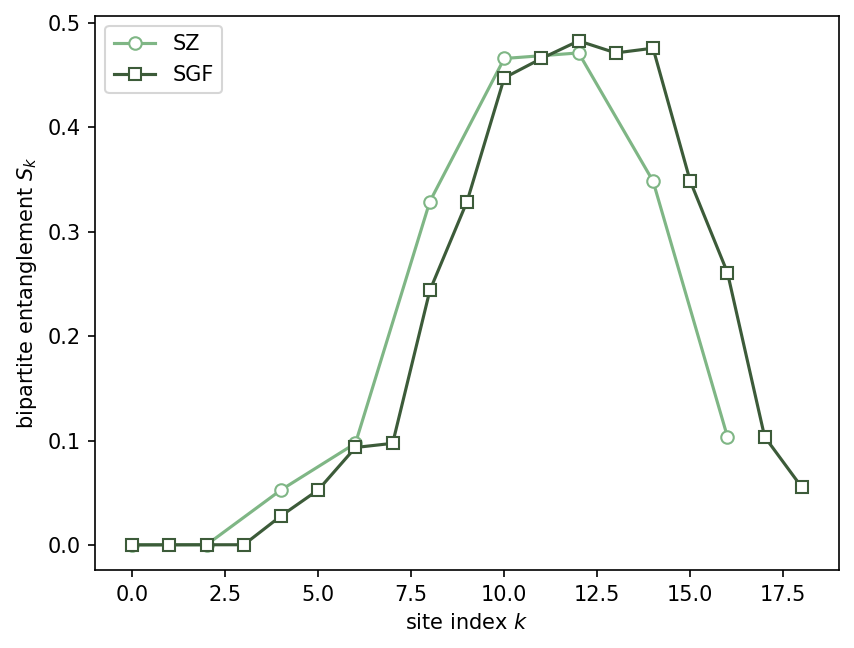

In [36]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(bip_ent_sz)) * 2, bip_ent_sz, linestyle='-', marker='o',
    mfc='white', mec="#7FB685", color="#7FB685", label='SZ')
plt.plot(np.arange(len(bip_ent_sgf)), bip_ent_sgf, linestyle='-', marker='s',
    mfc='white', mec="#3C5B39", color="#3C5B39", label='SGF')
plt.xlim((-1, ncas - 1))
plt.legend(loc='upper left')
plt.xlabel("site index $k$")
plt.ylabel("bipartite entanglement $S_k$")
plt.gcf().set_dpi(150)
plt.show()

## Orbital Entropy and Mutual Information

For the optimized MPS in the ``SZ``/``SGF`` mode, we can compute the 1- and 2- orbital density matrices and mutual information for pairs of orbitals.

In the ``SZ`` mode:


Sweep =    0 | Direction =  forward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      1.404 | E =    -107.6541224475 | DW = 4.14e-08

Sweep =    1 | Direction = backward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      2.188 | E =    -107.6541224475 | DE = -1.58e-11 | DW = 5.10e-09

Sweep =    2 | Direction =  forward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      2.906 | E =    -107.6541224475 | DE = -9.66e-13 | DW = 4.14e-08

Sweep =    3 | Direction = backward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      3.666 | E =    -107.6541224475 | DE = 1.48e-12 | DW = 5.15e-09

Sweep =    4 | Direction =  forward | Bond dimension =  500 | Noise =  1.00e-05 | Dav threshold =  1.00e-10
Time elapsed =      4.563 | E =    -107.6541224475 | DE = -7.11e-13 | DW = 3.61e-11

Sweep =    5 | Direction = backward | Bond dimension

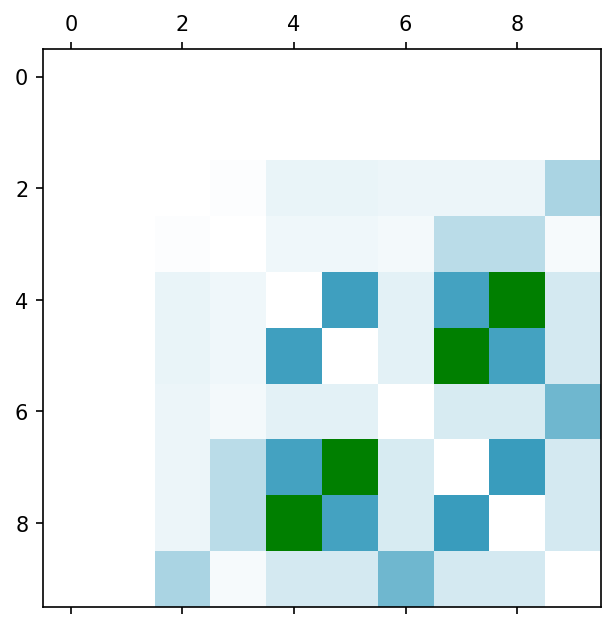

In [37]:
from pyscf import gto, scf

mol = gto.M(atom="N 0 0 0; N 0 0 1.1", basis="sto3g", symmetry="d2h", verbose=0)
mf = scf.RHF(mol).run(conv_tol=1E-14)
ncas, n_elec, spin, ecore, h1e, g2e, orb_sym = itg.get_rhf_integrals(mf,
    ncore=0, ncas=None, g2e_symm=8)

driver = DMRGDriver(scratch="./tmp", symm_type=SymmetryTypes.SZ, n_threads=4)
driver.initialize_system(n_sites=ncas, n_elec=n_elec, spin=spin, orb_sym=orb_sym)

mpo = driver.get_qc_mpo(h1e=h1e, g2e=g2e, ecore=ecore, iprint=0)
ket = driver.get_random_mps(tag="GS", bond_dim=250, nroots=1)
energy = driver.dmrg(mpo, ket, n_sweeps=20, bond_dims=bond_dims, noises=noises,
    thrds=thrds, iprint=1)
print('DMRG energy = %20.15f' % energy)

ordm1 = driver.get_orbital_entropies(ket, orb_type=1)
ordm2 = driver.get_orbital_entropies(ket, orb_type=2)
minfo = 0.5 * (ordm1[:, None] + ordm1[None, :] - ordm2) * (1 - np.identity(len(ordm1)))

import matplotlib.pyplot as plt
plt.matshow(minfo, cmap='ocean_r')
plt.gcf().set_dpi(150)
plt.show()

In the ``SGF`` mode:


Sweep =    0 | Direction =  forward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      1.852 | E =    -107.6541217988 | DW = 7.63e-08

Sweep =    1 | Direction = backward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      3.490 | E =    -107.6541223313 | DE = -5.33e-07 | DW = 7.48e-08

Sweep =    2 | Direction =  forward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      5.184 | E =    -107.6541224348 | DE = -1.04e-07 | DW = 7.65e-08

Sweep =    3 | Direction = backward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      6.857 | E =    -107.6541224348 | DE = 6.82e-12 | DW = 7.21e-08

Sweep =    4 | Direction =  forward | Bond dimension =  500 | Noise =  1.00e-05 | Dav threshold =  1.00e-10
Time elapsed =      8.588 | E =    -107.6541224379 | DE = -3.11e-09 | DW = 8.57e-11

Sweep =    5 | Direction = backward | Bond dimension

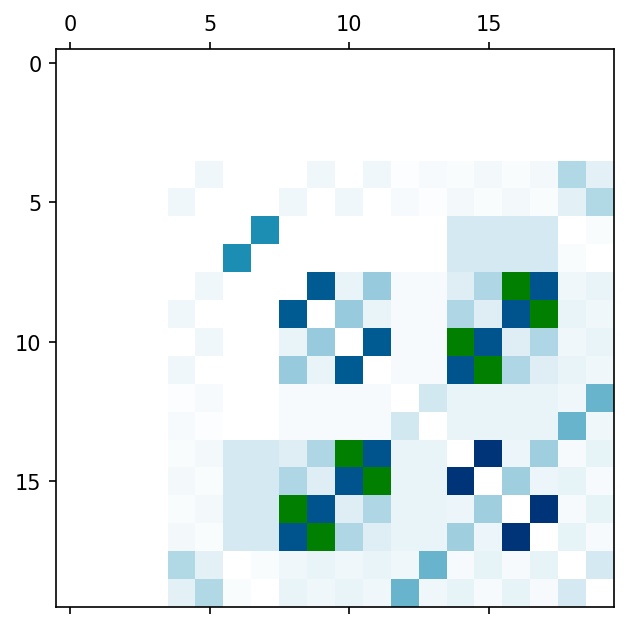

In [38]:
from pyscf import gto, scf

mol = gto.M(atom="N 0 0 0; N 0 0 1.1", basis="sto3g", symmetry="d2h", verbose=0)
mf = scf.GHF(mol).run(conv_tol=1E-14)
ncas, n_elec, spin, ecore, h1e, g2e, orb_sym = itg.get_ghf_integrals(mf,
    ncore=0, ncas=None, g2e_symm=8)

driver = DMRGDriver(scratch="./tmp", symm_type=SymmetryTypes.SGF, n_threads=4)
driver.initialize_system(n_sites=ncas, n_elec=n_elec, orb_sym=orb_sym)

mpo = driver.get_qc_mpo(h1e=h1e, g2e=g2e, ecore=ecore, iprint=0)
ket = driver.get_random_mps(tag="GS", bond_dim=250, nroots=1)
energy = driver.dmrg(mpo, ket, n_sweeps=20, bond_dims=bond_dims, noises=noises,
    thrds=thrds, iprint=1)
print('DMRG energy = %20.15f' % energy)

ordm1 = driver.get_orbital_entropies(ket, orb_type=1)
ordm2 = driver.get_orbital_entropies(ket, orb_type=2)
minfo = 0.5 * (ordm1[:, None] + ordm1[None, :] - ordm2) * (1 - np.identity(len(ordm1)))

import matplotlib.pyplot as plt
plt.matshow(minfo, cmap='ocean_r')
plt.gcf().set_dpi(150)
plt.show()

## Orbital Reordering

We support several algorithms (such as "fiedler" and "gaopt") to reorder the orbitals used in DMRG, so that the entanglement in the MPS can be decreased. With an optimal orbital reordering, one can expect a better energy expectation with a low bond dimension MPS.

The orbital reordering can be applied directly on the integrals ``h1e``, ``g2e`` (unpacked), and ``orb_sym`` (if there are point group symmetries), before they are used by ``pyblock2``. This is the recommended way, and the user is responsible for tracking the orbital ordering.

In the ``SZ`` mode (using the exchange integral as the cost function):


Sweep =    0 | Direction =  forward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      1.154 | E =    -107.6541224475 | DW = 3.94e-14

Sweep =    1 | Direction = backward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      1.779 | E =    -107.6541224475 | DE = -1.71e-13 | DW = 5.09e-14

Sweep =    2 | Direction =  forward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      2.519 | E =    -107.6541224475 | DE = 0.00e+00 | DW = 3.53e-14

Sweep =    3 | Direction = backward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      3.267 | E =    -107.6541224475 | DE = -1.71e-13 | DW = 5.99e-14

Sweep =    4 | Direction =  forward | Bond dimension =  500 | Noise =  1.00e-05 | Dav threshold =  1.00e-10
Time elapsed =      4.325 | E =    -107.6541224475 | DE = -2.84e-14 | DW = 1.60e-19

Sweep =    5 | Direction = backward | Bond dimension

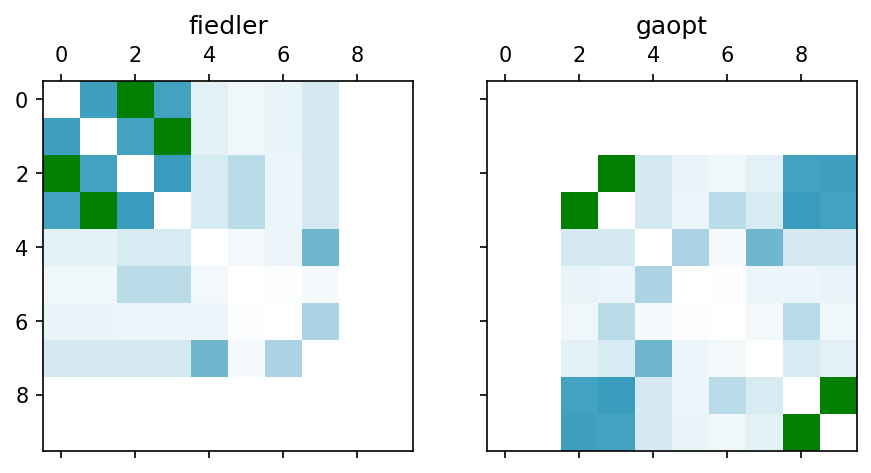

In [39]:
from pyscf import gto, scf

mol = gto.M(atom="N 0 0 0; N 0 0 1.1", basis="sto3g", symmetry="d2h", verbose=0)
mf = scf.RHF(mol).run(conv_tol=1E-14)
ncas, n_elec, spin, ecore, h1e_orig, g2e_orig, orb_sym_orig = itg.get_rhf_integrals(mf,
    ncore=0, ncas=None, g2e_symm=8)

driver = DMRGDriver(scratch="./tmp", symm_type=SymmetryTypes.SZ, n_threads=4)
g2e_orig = driver.unpack_g2e(g2e_orig, n_sites=ncas)

minfos = {}
for method in ["fiedler", "gaopt"]:
    idx = driver.orbital_reordering(h1e_orig, g2e_orig, method=method)
    h1e = h1e_orig[idx][:, idx]
    g2e = g2e_orig[idx][:, idx][:, :, idx][:, :, :, idx]
    orb_sym = np.array(orb_sym_orig)[idx]

    driver.initialize_system(n_sites=ncas, n_elec=n_elec, spin=spin, orb_sym=orb_sym)
    mpo = driver.get_qc_mpo(h1e=h1e, g2e=g2e, ecore=ecore, iprint=0)
    ket = driver.get_random_mps(tag="GS", bond_dim=250, nroots=1)
    energy = driver.dmrg(mpo, ket, n_sweeps=20, bond_dims=bond_dims, noises=noises,
        thrds=thrds, iprint=1)
    print('Method = %s DMRG energy = %20.15f' % (method, energy))
    minfos[method] = driver.get_orbital_interaction_matrix(ket)

import matplotlib.pyplot as plt
f, axs = plt.subplots(1, 2, sharey=True)
f.set_size_inches(w=14 / 2, h=7 / 2)
for ax, (method, minfo) in zip(axs, minfos.items()):
    ax.matshow(minfo, cmap='ocean_r')
    ax.set_title(method)
plt.gcf().set_dpi(150)
plt.show()

In the ``SGF`` mode (using the exchange integral as the cost function):


Sweep =    0 | Direction =  forward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      4.089 | E =    -107.6421167128 | DW = 1.94e-08

Sweep =    1 | Direction = backward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      6.269 | E =    -107.6541224404 | DE = -1.20e-02 | DW = 2.02e-08

Sweep =    2 | Direction =  forward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      7.843 | E =    -107.6541224449 | DE = -4.57e-09 | DW = 2.63e-08

Sweep =    3 | Direction = backward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      9.347 | E =    -107.6541224419 | DE = 3.04e-09 | DW = 2.48e-08

Sweep =    4 | Direction =  forward | Bond dimension =  500 | Noise =  1.00e-05 | Dav threshold =  1.00e-10
Time elapsed =     11.393 | E =    -107.6541224475 | DE = -5.62e-09 | DW = 2.71e-11

Sweep =    5 | Direction = backward | Bond dimension

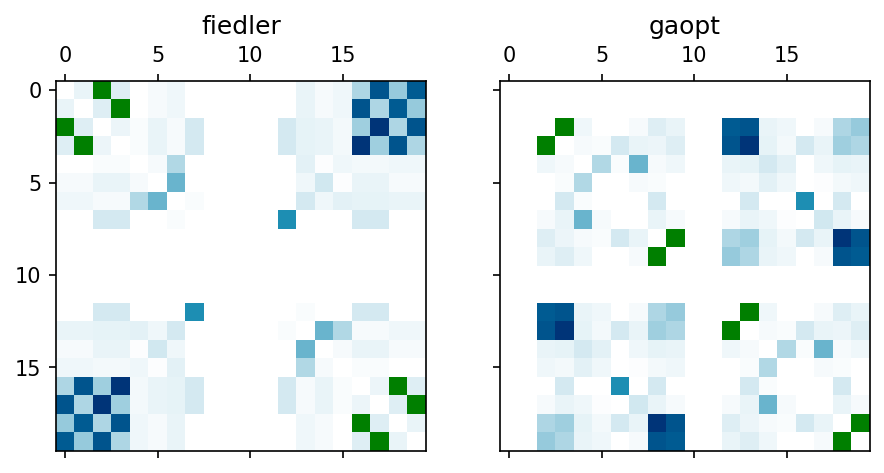

In [40]:
from pyscf import gto, scf

mol = gto.M(atom="N 0 0 0; N 0 0 1.1", basis="sto3g", symmetry="d2h", verbose=0)
mf = scf.GHF(mol).run(conv_tol=1E-14)
ncas, n_elec, spin, ecore, h1e_orig, g2e_orig, orb_sym_orig = itg.get_ghf_integrals(mf,
    ncore=0, ncas=None, g2e_symm=8)

driver = DMRGDriver(scratch="./tmp", symm_type=SymmetryTypes.SGF, n_threads=4)
g2e_orig = driver.unpack_g2e(g2e_orig, n_sites=ncas)

minfos = {}
for method in ["fiedler", "gaopt"]:
    idx = driver.orbital_reordering(h1e_orig, g2e_orig, method=method)
    h1e = h1e_orig[idx][:, idx]
    g2e = g2e_orig[idx][:, idx][:, :, idx][:, :, :, idx]
    orb_sym = np.array(orb_sym_orig)[idx]

    driver.initialize_system(n_sites=ncas, n_elec=n_elec, orb_sym=orb_sym)
    mpo = driver.get_qc_mpo(h1e=h1e, g2e=g2e, ecore=ecore, iprint=0)
    ket = driver.get_random_mps(tag="GS", bond_dim=250, nroots=1)
    energy = driver.dmrg(mpo, ket, n_sweeps=20, bond_dims=bond_dims, noises=noises,
        thrds=thrds, iprint=1)
    print('Method = %s DMRG energy = %20.15f' % (method, energy))
    minfos[method] = driver.get_orbital_interaction_matrix(ket)

import matplotlib.pyplot as plt
f, axs = plt.subplots(1, 2, sharey=True)
f.set_size_inches(w=14 / 2, h=7 / 2)
for ax, (method, minfo) in zip(axs, minfos.items()):
    ax.matshow(minfo, cmap='ocean_r')
    ax.set_title(method)
plt.gcf().set_dpi(150)
plt.show()

The orbital reordering can also be done implicitly using the ``reorder`` argument in ``DMRGDriver.get_qc_mpo``. ``pyblock2`` will automatically recover the original ordering for observables, whenever possible, such as $N$-PDMs. But ordering for quantities like bipartite/orbital entropy are not recovered (kept as the computational ordering since they are indicators of the orbital topology). In order to avoid any confusion, this implicit reordering approach is not recommended unless only the ground state energy and $N$-PDMs are needed.

Implicit orbital reordering using ``gaopt`` in the ``SZ`` mode:

In [41]:
from pyscf import gto, scf

mol = gto.M(atom="N 0 0 0; N 0 0 1.1", basis="sto3g", symmetry="d2h", verbose=0)
mf = scf.RHF(mol).run(conv_tol=1E-14)
ncas, n_elec, spin, ecore, h1e, g2e, orb_sym = itg.get_rhf_integrals(mf,
    ncore=0, ncas=None, g2e_symm=8)

driver = DMRGDriver(scratch="./tmp", symm_type=SymmetryTypes.SZ, n_threads=4)
driver.initialize_system(n_sites=ncas, n_elec=n_elec, spin=spin, orb_sym=orb_sym)
mpo = driver.get_qc_mpo(h1e=h1e, g2e=g2e, ecore=ecore, reorder="gaopt", iprint=0)
ket = driver.get_random_mps(tag="GS", bond_dim=250, nroots=1)
energy = driver.dmrg(mpo, ket, n_sweeps=20, bond_dims=bond_dims, noises=noises,
    thrds=thrds, iprint=1)
print('DMRG energy = %20.15f' % energy)


Sweep =    0 | Direction =  forward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      0.869 | E =    -107.6541224475 | DW = 4.11e-10

Sweep =    1 | Direction = backward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      1.480 | E =    -107.6541224475 | DE = -1.18e-11 | DW = 4.28e-11

Sweep =    2 | Direction =  forward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      2.116 | E =    -107.6541224475 | DE = -2.10e-12 | DW = 4.13e-10

Sweep =    3 | Direction = backward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      2.707 | E =    -107.6541224475 | DE = -1.42e-13 | DW = 4.76e-11

Sweep =    4 | Direction =  forward | Bond dimension =  500 | Noise =  1.00e-05 | Dav threshold =  1.00e-10
Time elapsed =      3.456 | E =    -107.6541224475 | DE = -8.53e-14 | DW = 1.46e-20

Sweep =    5 | Direction = backward | Bond dimensio

One can also run a small bond dimension DMRG with the default orbital ordering to get the mutual information for orbital correlation, then use this matrix as the cost function to get the orbital ordering for doing more efficient DMRG (this is supported in the ``SZ`` and ``SGF`` modes). See the following example.

In the ``SGF`` mode (using the mutual information as the cost function):


Sweep =    0 | Direction =  forward | Bond dimension =   50 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      0.790 | E =    -107.6461019596 | DW = 1.12e-04

Sweep =    1 | Direction = backward | Bond dimension =   50 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      1.199 | E =    -107.6518646319 | DE = -5.76e-03 | DW = 8.45e-05

Sweep =    2 | Direction =  forward | Bond dimension =   50 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      1.658 | E =    -107.6524131412 | DE = -5.49e-04 | DW = 4.76e-05

Sweep =    3 | Direction = backward | Bond dimension =   50 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      2.123 | E =    -107.6524673390 | DE = -5.42e-05 | DW = 4.58e-05

Sweep =    4 | Direction =  forward | Bond dimension =   50 | Noise =  1.00e-05 | Dav threshold =  1.00e-10
Time elapsed =      2.589 | E =    -107.6525301747 | DE = -6.28e-05 | DW = 3.18e-05

Sweep =    5 | Direction = backward | Bond dimensio

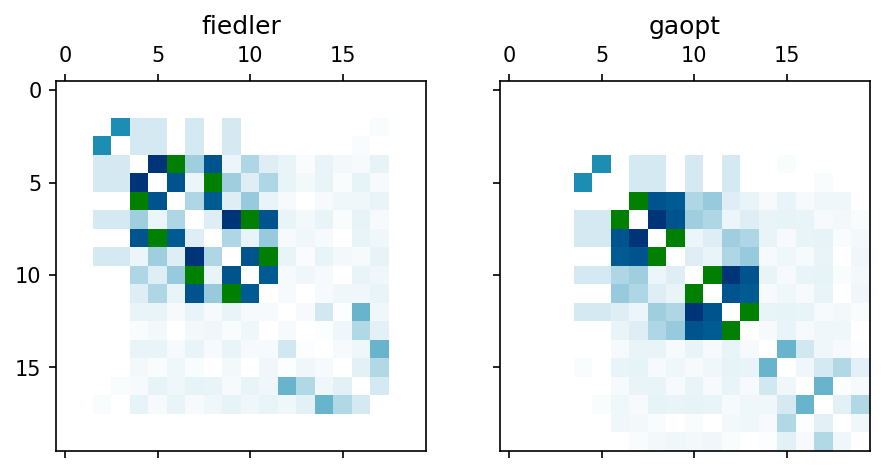

In [43]:
from pyscf import gto, scf

mol = gto.M(atom="N 0 0 0; N 0 0 1.1", basis="sto3g", symmetry="d2h", verbose=0)
mf = scf.GHF(mol).run(conv_tol=1E-14)
ncas, n_elec, spin, ecore, h1e_orig, g2e_orig, orb_sym_orig = itg.get_ghf_integrals(mf,
    ncore=0, ncas=None, g2e_symm=8)

driver = DMRGDriver(scratch="./tmp", symm_type=SymmetryTypes.SGF, n_threads=4)
g2e_orig = driver.unpack_g2e(g2e_orig, n_sites=ncas)

# approx DMRG to get orbital_interaction_matrix
driver.initialize_system(n_sites=ncas, n_elec=n_elec, orb_sym=orb_sym_orig)
mpo = driver.get_qc_mpo(h1e=h1e_orig, g2e=g2e_orig, ecore=ecore, iprint=0)
ket = driver.get_random_mps(tag="GS", bond_dim=50, nroots=1)
energy = driver.dmrg(mpo, ket, n_sweeps=10, bond_dims=[50] * 8, noises=noises,
    thrds=thrds, iprint=1)
print('Approx DMRG energy = %20.15f' % energy)
minfo_orig = driver.get_orbital_interaction_matrix(ket)

minfos = {}
for method in ["fiedler", "gaopt"]:
    idx = driver.orbital_reordering_interaction_matrix(minfo_orig, method=method)
    h1e = h1e_orig[idx][:, idx]
    g2e = g2e_orig[idx][:, idx][:, :, idx][:, :, :, idx]
    orb_sym = np.array(orb_sym_orig)[idx]

    driver.initialize_system(n_sites=ncas, n_elec=n_elec, spin=spin, orb_sym=orb_sym)
    mpo = driver.get_qc_mpo(h1e=h1e, g2e=g2e, ecore=ecore, iprint=0)
    ket = driver.get_random_mps(tag="GS", bond_dim=250, nroots=1)
    energy = driver.dmrg(mpo, ket, n_sweeps=20, bond_dims=bond_dims, noises=noises,
        thrds=thrds, iprint=1)
    print('Method = %s DMRG energy = %20.15f' % (method, energy))
    minfos[method] = driver.get_orbital_interaction_matrix(ket)

import matplotlib.pyplot as plt
f, axs = plt.subplots(1, 2, sharey=True)
f.set_size_inches(w=14 / 2, h=7 / 2)
for ax, (method, minfo) in zip(axs, minfos.items()):
    ax.matshow(minfo, cmap='ocean_r')
    ax.set_title(method)
plt.gcf().set_dpi(150)
plt.show()

## Excited States

To obtain the excited states and their energies, we can perform DMRG for a state-averged MPS, optionally followed by a state-specific refinement.

In [44]:
from pyscf import gto, scf

mol = gto.M(atom="N 0 0 0; N 0 0 1.1", basis="sto3g", symmetry="d2h", verbose=0)
mf = scf.RHF(mol).run(conv_tol=1E-14)
ncas, n_elec, spin, ecore, h1e, g2e, orb_sym = itg.get_rhf_integrals(mf,
    ncore=0, ncas=None, g2e_symm=8)

driver = DMRGDriver(scratch="./tmp", symm_type=SymmetryTypes.SZ, n_threads=4)
driver.initialize_system(n_sites=ncas, n_elec=n_elec, spin=spin, orb_sym=orb_sym)

mpo = driver.get_qc_mpo(h1e=h1e, g2e=g2e, ecore=ecore, iprint=0)

ket = driver.get_random_mps(tag="KET", bond_dim=100, nroots=3)
energies = driver.dmrg(mpo, ket, n_sweeps=10, bond_dims=[100], noises=[1e-5] * 4 + [0],
    thrds=[1e-10] * 8, iprint=1)
print('State-averaged MPS energies = [%s]' % " ".join("%20.15f" % x for x in energies))

kets = [driver.split_mps(ket, ir, tag="KET-%d" % ir) for ir in range(ket.nroots)]
for ir in range(ket.nroots):
    energy = driver.dmrg(mpo, kets[ir], n_sweeps=10, bond_dims=[200], noises=[1e-5] * 4 + [0],
        thrds=[1e-10] * 8, iprint=0, proj_weights=[5.0] * ir, proj_mpss=kets[:ir])
    print('State-specific MPS E[%d] = %20.15f' % (ir, energy))


Sweep =    0 | Direction =  forward | Bond dimension =  100 | Noise =  1.00e-05 | Dav threshold =  1.00e-10
Time elapsed =      1.873 | E[  3] =    -107.6541184424   -107.0314355209   -106.9595839138 | DW = 8.49e-05

Sweep =    1 | Direction = backward | Bond dimension =  100 | Noise =  1.00e-05 | Dav threshold =  1.00e-10
Time elapsed =      2.807 | E[  3] =    -107.6541184424   -107.0314355209   -106.9595839138 | DE = -1.51e-11 | DW = 1.61e-04

Sweep =    2 | Direction =  forward | Bond dimension =  100 | Noise =  1.00e-05 | Dav threshold =  1.00e-10
Time elapsed =      3.640 | E[  3] =    -107.6541138875   -107.0314486179   -106.9594564029 | DE = 1.28e-04 | DW = 7.20e-05

Sweep =    3 | Direction = backward | Bond dimension =  100 | Noise =  1.00e-05 | Dav threshold =  1.00e-10
Time elapsed =      4.520 | E[  3] =    -107.6541138875   -107.0314486178   -106.9594564029 | DE = -9.18e-12 | DW = 1.47e-04

Sweep =    4 | Direction =  forward | Bond dimension =  100 | Noise =  0.00e+00 |